<b>Question</b>
Are employees who have only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been at the job longer?

In [265]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [266]:
dete_survey = pd.read_csv("dete_survey.csv")
tafe_survey = pd.read_csv("tafe_survey.csv")

Department of Education, Training and Employment <b>(DETE)</b>
Technical and Further Education <b>(TAFE)</b> institute in Queensland, Australia

In [267]:
dete_survey.columns = dete_survey.columns.str.upper().str.replace('\s+', ' ')
#print(dete_survey.head())

In [268]:
tafe_survey.columns = tafe_survey.columns.str.upper().str.replace("."," ").str.replace('\s+', ' ')

'''
Converting column names that include TOPIC:[0-9], to just TOPIC:[0-9]
'''
def change(Tcolumns):
    pattern = re.compile(r"TOPIC:[0-9]")
    columns = []
    for column in Tcolumns:
        if re.search(pattern,column):
            word = pattern.findall(column)
            columns.append(word[0])
        else:
            columns.append(column)
    return columns
columns = change(tafe_survey.columns)
tafe_survey.columns = columns
#print(tafe_survey.head())

In [269]:
'''
A function that returns the columns that contain at least 10% NaN
'''
def null(df):
    nulls = []
    for i in range(df.shape[1]): #number of columns
        sr = df.iloc[:,i] #creates a series of each column
        if (sr.isnull().sum()/sr.size) > 0.1: #check for 10%
            nulls.append(df.columns[i]) #appends columns name
    return nulls

nullsD = null(dete_survey)
nulldT = null(tafe_survey)

In [270]:
dete_survey = pd.read_csv("dete_survey.csv", na_values = ["Not Stated"])
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49],axis = 1)
print(dete_survey_updated.shape)

(822, 35)


In [271]:
tafe_survey = pd.read_csv("tafe_survey.csv", na_values = ["Not Stated"])
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[28:49],axis = 1)
print(tafe_survey_updated.shape)

(702, 51)


<b>Renaming Columns</b>
Renanme columns and making the names of the 2 dataframes as compatible as possible.

In [272]:
dete_survey_updated.columns = dete_survey_updated.columns.str.lower().str.strip().str.replace(" ","_")

In [273]:
rn = {'Record ID': 'id','CESSATION YEAR': 'cease_date','Reason for ceasing employment': 'separationtype','Gender. What is your Gender?': 'gender','CurrentAge. Current Age': 'age','Employment Type. Employment Type': 'employment_status','Classification. Classification': 'position','LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service','LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}
tafe_survey_updated = tafe_survey_updated.rename(rn,axis = 1)
#print(tafe_survey_updated.columns)

In [274]:
print(dete_survey_updated["separationtype"].head())

0               Ill Health Retirement
1    Voluntary Early Retirement (VER)
2    Voluntary Early Retirement (VER)
3           Resignation-Other reasons
4                      Age Retirement
Name: separationtype, dtype: object


In [275]:
print(dete_survey_updated['separationtype'].value_counts())

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64


In [276]:
print(tafe_survey_updated['separationtype'].value_counts())

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64


<b>Cleaning Data<b>

Taking the data of the people that resigned

In [277]:
dete_resignations = dete_survey_updated[dete_survey_updated["separationtype"].str.contains("Resignation")].copy()
tafe_resignations = tafe_survey_updated[tafe_survey_updated["separationtype"] == "Resignation"].copy()

Fixing how the dates are shown

In [278]:
print(dete_resignations["cease_date"].value_counts())

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
11/2013      9
07/2013      9
10/2013      6
08/2013      4
05/2013      2
05/2012      2
07/2012      1
09/2010      1
07/2006      1
2010         1
Name: cease_date, dtype: int64


Only interested in the last date, not the intermidiate

In [279]:
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.split("/").str[-1].astype(float).sort_index(ascending = True)
print(dete_resignations['cease_date'].value_counts())

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_date, dtype: int64


In [280]:
print(tafe_resignations["cease_date"].value_counts())

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64


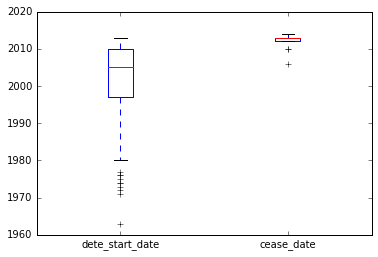

In [281]:
dete_resignations[["dete_start_date","cease_date"]].plot(kind='box')

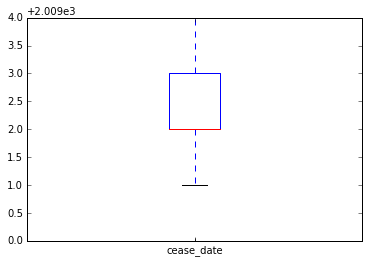

In [282]:
tafe_resignations[["cease_date"]].plot(kind='box')
#print(tafe_resignations.columns)

In [283]:
dete_resignations["institute_service"] = dete_resignations["cease_date"] - dete_resignations["dete_start_date"]

By creating the "institutive_service" column, we can analyse both surveys together.

In [284]:
print(tafe_resignations[["Contributing Factors. Dissatisfaction"]].head(20))

     Contributing Factors. Dissatisfaction
3                                        -
4                                        -
5                                        -
6                                        -
7                                        -
8                                        -
9                                        -
10                                       -
13                                       -
14  Contributing Factors. Dissatisfaction 
15                                       -
16                                     NaN
17                                       -
18                                     NaN
19                                       -
20  Contributing Factors. Dissatisfaction 
21                                       -
22                                       -
23                                       -
24                                       -


<b>Dissatisfied employees</b>
Using the columns that show employees are not happy and conveting the to booleans.

In [285]:
def update_vals(element):
    if element == "-":
        return False
    elif pd.isnull(element):
        return np.nan
    else:
        return True

In [286]:
dete = ["job_dissatisfaction","dissatisfaction_with_the_department","physical_work_environment","lack_of_recognition","lack_of_job_security","work_location","employment_conditions","work_life_balance","workload"]
dete_resignations[dete] = dete_resignations[dete].applymap(update_vals)

tafe = ["Contributing Factors. Dissatisfaction","Contributing Factors. Job Dissatisfaction"] 
tafe_resignations[tafe] = tafe_resignations[tafe].applymap(update_vals)

The "dissatisfied" column consists of booleans, whether someone was Sattisfied, Dissatisfied or dint mention (NaN)

In [287]:
dete_resignations["dissatisfied"] = dete_resignations[dete].any(axis = 1,skipna = False)
tafe_resignations["dissatisfied"] = tafe_resignations[tafe].any(axis = 1,skipna = False)

In [288]:
dete_resignations_up = dete_resignations.copy()
tafe_resignations_up = tafe_resignations.copy()

<b>Merging Data </b>
Dataframes are combined and columns with less than 500 non-null values are removed.

In [289]:
dete_resignations_up["institute"] = "DETE"
tafe_resignations_up["institute"] = "TAFE"

In [290]:
combined = pd.concat([dete_resignations_up,tafe_resignations_up],axis = 0,ignore_index = True)
print(combined.shape)
combined_updated = combined.dropna(thresh = 500,axis = 1)
print(combined_updated.shape)

(651, 81)
(651, 10)


In [291]:
#print(combined_updated["institute_service"].value_counts())
#understand format of institute_service column

In [299]:
'''
Create a function to classify people based on the amount of years in the workplace
'''
def mapping(element):
    if "-" in element:
        aver = (float(element[0]) + float(element[-1]))/2
        serv = aver
    elif pd.isnull(element):
        return np.nan
    elif re.findall(r'\d+',element):
        x = re.findall(r'\d+',element)
        serv = float(x[0])
    else:
        serv = float(element)
    if serv > 11:
        return "Veteran"
    elif serv > 7:
        return "Established"
    elif serv > 3:
        return "Experienced"
    else:
        return "New"
    

In [304]:
combined_updated_v2 = combined_updated.copy()
combined_updated_v2["service_cat"] = combined_updated_v2["institute_service"].astype(str).map(mapping)
print(combined_updated_v2["service_cat"].head())

0    Experienced
1        Veteran
2            New
3        Veteran
4            New
Name: service_cat, dtype: object


In [305]:
combined_updated['dissatisfied'].value_counts(dropna=False)

True     402
False    249
Name: dissatisfied, dtype: int64

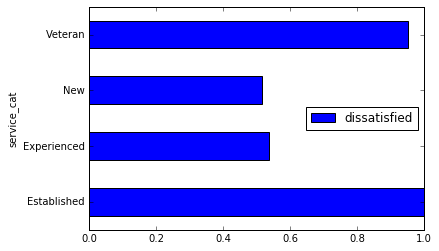

In [307]:
combined_updated_v2['dissatisfied'] = combined_updated_v2['dissatisfied'].fillna(False)
table = pd.pivot_table(combined_updated_v2, index='service_cat', values='dissatisfied', aggfunc = "mean")
table.plot(kind='barh')